# SD212: Graph mining
## Lab 1: Graph structure

In this lab, you will check three structural properties of real graphs:
* the [power-law](https://en.wikipedia.org/wiki/Power_law#Power-law_probability_distributions) of degrees,
* the [small-world](https://en.wikipedia.org/wiki/Small-world_network) property,
* the tendency to [cluster](https://en.wikipedia.org/wiki/Clustering_coefficient).

## Import

In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

In [2]:
from sknetwork.data import load_netset, erdos_renyi
from sknetwork.path import get_distances, get_diameter, get_shortest_path
from sknetwork.utils import bipartite2undirected
from sknetwork.topology import Triangles

In [3]:
import pandas as pd

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paris.fr) collection for details):
* Openflights (graph)
* WikiVitals (directed graph)
* Cinema (bipartite graph)

In [4]:
openflights = load_netset('openflights')

Parsing files...
Done.


In [5]:
type(openflights)

sknetwork.utils.Bunch

In [6]:
# weighted adjacency matrix
adjacency = openflights.adjacency

In [7]:
# binary adjacency matrix
adjacency = adjacency > 0

In [8]:
adjacency

<3097x3097 sparse matrix of type '<class 'numpy.bool_'>'
	with 36386 stored elements in Compressed Sparse Row format>

In [9]:
wikivitals = load_netset('wikivitals')

Parsing files...
Done.


In [10]:
cinema = load_netset('cinema')

Parsing files...
Done.


## 1. Power law

We first focus on the power law degree distribution.

We consider the empirical distributions of:
* degrees in the Openflights graph,
* in-degrees and out-degrees in the WikiVitals graph.

## To do

For each of these distributions:
* Plot the [tail distribution](https://en.wikipedia.org/wiki/Cumulative_distribution_function#Complementary_cumulative_distribution_function_(tail_distribution)) in log-log scale.
* Conclude: do you consider that these are power-law graphs?

In [10]:
def plot_loglog(degrees):
    """Plot the degree distribution in log-log scale and compare with that of a random graph.
    
    Parameters
    ----------
    degrees : array
        vector of degrees of the graph.
    """
    n = len(degrees)
    # comparison with a random graph
    adjacency_random = erdos_renyi(n, np.sum(degrees) / n / (n-1))
    degrees_random = adjacency_random.dot(np.ones(n))
    plt.loglog(np.sort(degrees, axis=0), 1 - np.arange(n) / n, lw = 3, label='Real graph')
    plt.loglog(np.sort(degrees_random), 1 - np.arange(n) / n, lw = 3, label = 'Random graph')
    plt.xlabel('Degree')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

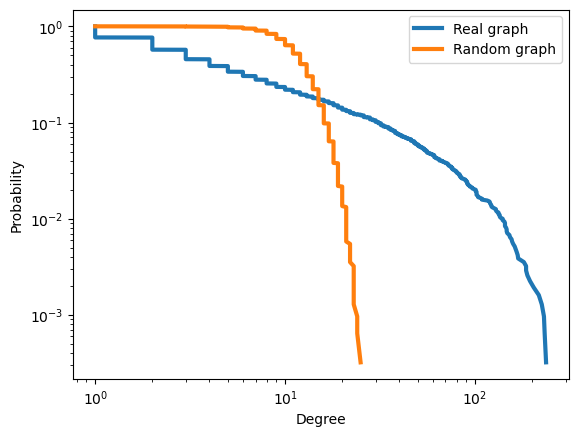

In [11]:
plot_loglog(np.sum(openflights.adjacency>0, axis=1))

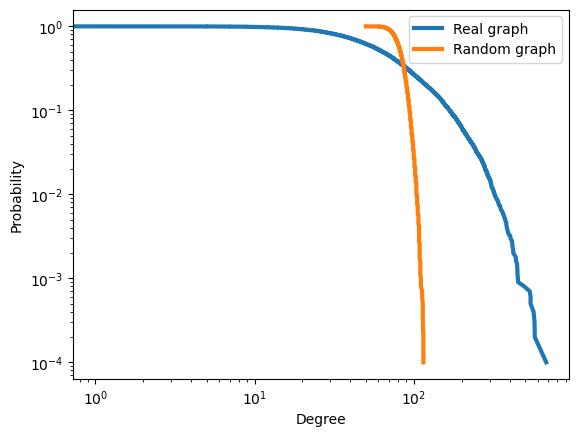

In [12]:
plot_loglog(np.sum(wikivitals.adjacency, axis=1))

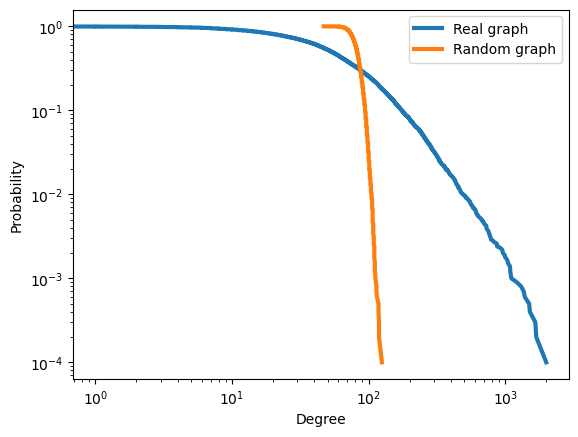

In [13]:
plot_loglog(np.sum(wikivitals.adjacency, axis=0).reshape(-1,1))

## 2. Small-world

You will now make a few experiments highlighting the small-world property.

## To do

* Give a shortest path of maximum length starting from **Paris Charles de Gaulle** airport in Openflights.<br> 
List the corresponding airports.
* Give a shortest path from [Plato](https://en.wikipedia.org/wiki/Plato) to [Platini](https://en.wikipedia.org/wiki/Michel_Platini) in WikiVitals.<br>
List the corresponding articles.

In [59]:
articles_list = get_shortest_path(wikivitals.adjacency, int(np.where(wikivitals.names == 'Plato')[0]), int(np.where(wikivitals.names == 'Michel Platini')[0]))
for article in articles_list:
    print(wikivitals.names[article])

Plato
Émile Durkheim
France
Michel Platini


In [51]:
np.where(wikivitals.names == 'Platini')

(array([], dtype=int64),)

In [9]:
import pandas as pd

In [56]:
np.where(pd.Series(wikivitals.names).str.contains("Platini"))

(array([5893], dtype=int64),)

In [57]:
wikivitals.names[5893]

'Michel Platini'

In [30]:
from sknetwork.utils import get_neighbors

1968

In [23]:
openflights

{'adjacency': <3097x3097 sparse matrix of type '<class 'numpy.int64'>'
 	with 36386 stored elements in Compressed Sparse Row format>,
 'meta': {'name': 'openflights',
  'description': 'Airports with daily number of flights between them.',
  'source': 'https://openflights.org'},
 'names': array(['Goroka Airport', 'Madang Airport', 'Mount Hagen Kagamuga Airport',
        ..., 'Saumlaki/Olilit Airport', 'Tarko-Sale Airport',
        'Alashankou Bole (Bortala) airport'], dtype='<U65'),
 'position': array([[145.39199829,  -6.08168983],
        [145.78900147,  -5.20707989],
        [144.29600525,  -5.82678986],
        ...,
        [131.30599976,  -7.98860979],
        [ 77.81809998,  64.93080139],
        [ 82.3       ,  44.895     ]])}

In [13]:
openflights.adjacency[openflights.names=='Charles de Gaulle International Airport']

<1x3097 sparse matrix of type '<class 'numpy.int64'>'
	with 233 stored elements in Compressed Sparse Row format>

In [15]:
import pandas as pd
openflights.adjacency[pd.Series(openflights.names).str.contains('Charles de Gaulle')]

<1x3097 sparse matrix of type '<class 'numpy.int64'>'
	with 233 stored elements in Compressed Sparse Row format>

## To do

* Which fraction of the airports can be reached from **Paris Charles de Gaulle** in 1, 2, 3 flights?
* Which fraction of the articles can be reached from **Paris** in 1, 2, 3 clicks on Wikipedia Vitals?

In [16]:
cdg = int(np.where(pd.Series(openflights.names).str.contains('Charles de Gaulle'))[0])

In [19]:
cdg

622

In [18]:
airport_distance = get_distances(openflights.adjacency, sources=cdg)

In [27]:
print(sum(airport_distance==1)/len(openflights.names))
print(sum((airport_distance==1) | (airport_distance==2))/len(openflights.names))
print(sum((airport_distance==1) | (airport_distance==2) | (airport_distance==3))/len(openflights.names))

0.04488214401033258
0.3813367775266387
0.7216661285114627


In [34]:
paris = int(np.where(wikivitals.names=='Paris')[0])

In [35]:
paris

6816

In [39]:
article_click = get_distances(wikivitals.adjacency, sources=paris)
print(sum(article_click==1)/len(wikivitals.names))
print(sum((article_click==1) | (article_click==2))/len(wikivitals.names))
print(sum((article_click==1) | (article_click==2) | (article_click==3))/len(wikivitals.names))


0.039456597742483265
0.6740585356108281
0.9932074717810409


## To do

* Compute the [Bacon number](https://fr.wikipedia.org/wiki/Six_Degrees_of_Kevin_Bacon) of all actors (**without** building the co-starring actor graph).
* Plot the corresponding histogram.

In [40]:
cinema

{'biadjacency': <88440x44586 sparse matrix of type '<class 'numpy.bool_'>'
 	with 304006 stored elements in Compressed Sparse Row format>,
 'meta': {'name': 'cinema',
  'source': 'https://yago-knowledge.org',
  'description': 'Graph between movies and actors.'},
 'names_col': array(['Joe E. Brown', 'Eric Blore', 'Susan Hayward', ...,
        'Olivier Saladin', 'Reona Hirota', 'Leyla Sayar'], dtype='<U95'),
 'names_row': array(['$1,000 a Touchdown', '$9.99', '$', ...,
        'Šta se zgodi kad se ljubav rodi', 'Želary', '’O Re'], dtype='<U95')}

In [18]:
adjacency = bipartite2undirected(cinema.biadjacency)

In [44]:
adjacency

<133026x133026 sparse matrix of type '<class 'numpy.bool_'>'
	with 608012 stored elements in Compressed Sparse Row format>

In [19]:
bacon = int(np.where(pd.Series(cinema.names_col).str.contains('Kevin Bacon'))[0])

In [20]:
n_movie, n_actor = cinema.biadjacency.shape

In [21]:
bacon_number = get_distances(adjacency, sources=bacon + n_movie)

In [22]:
bacon_number_actor = bacon_number[n_movie:]

(array([1.0000e+00, 0.0000e+00, 2.1900e+02, 0.0000e+00, 6.6930e+03,
        0.0000e+00, 1.8781e+04, 0.0000e+00, 1.4084e+04, 0.0000e+00,
        3.9950e+03, 0.0000e+00, 6.3200e+02, 0.0000e+00, 1.2700e+02,
        0.0000e+00, 2.9000e+01, 0.0000e+00, 9.0000e+00, 0.0000e+00,
        3.0000e+00, 0.0000e+00, 5.0000e+00, 0.0000e+00, 5.0000e+00,
        3.0000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26.]),
 <BarContainer object of 26 artists>)

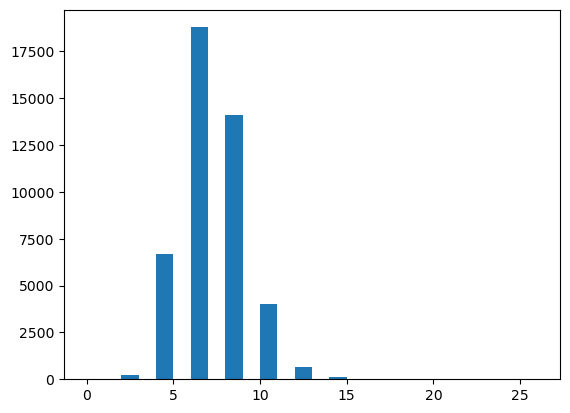

In [24]:
plt.hist(bacon_number_actor, bins=26)

## 3. Clustering coefficient

Finally, we check the clustering property of real graph (my friends tend to be friends).

## To do


* Compute the clustering coefficient of Openflights and WikiVitals (seen as an undirected graph).
* Compare with that of a random graph of same size.

In [71]:
coefficient_openflights = Triangles().fit_transform(openflights.adjacency>0)
coefficient_openflights

96340

In [15]:
n = openflights.adjacency.shape[0]
adjacency_random_1 = erdos_renyi(n, np.sum(openflights.adjacency>0) / n / (n-1))
random_coefficient_1 = Triangles().fit_transform(adjacency_random_1)
random_coefficient_1

267

In [72]:
coefficient_wikivitals = Triangles().fit_transform(wikivitals.adjacency)
coefficient_wikivitals

3925423

In [16]:
n = wikivitals.adjacency.shape[0]
adjacency_random_2 = erdos_renyi(n, np.sum(wikivitals.adjacency) / n / (n-1))
random_coefficient_2 = Triangles().fit_transform(adjacency_random_2)
random_coefficient_2

93748